In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


2025-07-11 08:04:29.830182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752221070.030815      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752221070.089195      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

In [6]:
df['emotion_label'] = df['emotion'].map(emotion_label_to_text)

In [7]:
df.emotion_label.value_counts()

emotion_label
happiness    8989
neutral      6198
sadness      6077
fear         5121
anger        4953
surprise     4002
disgust       547
Name: count, dtype: int64

In [8]:
df.head()

,emotion,pixels,Usage,emotion_label
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,anger
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,anger
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,sadness
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,neutral


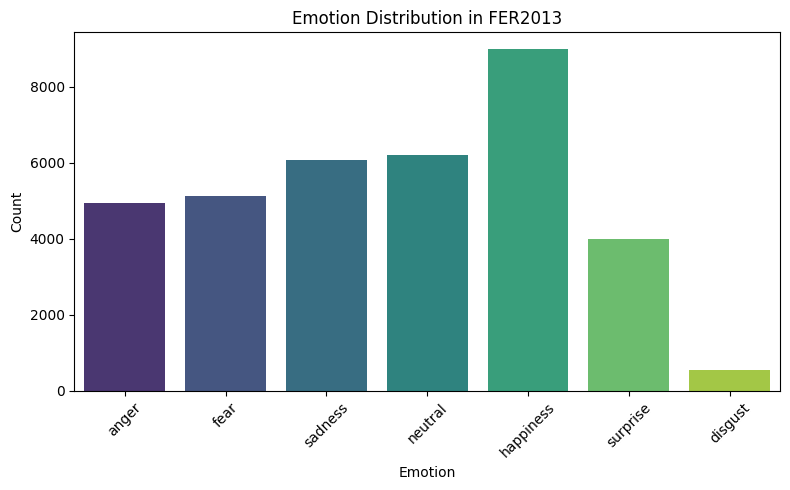

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='emotion_label', data=df, palette='viridis')

plt.title("Emotion Distribution in FER2013")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

/tmp/ipykernel_35/1811356828.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


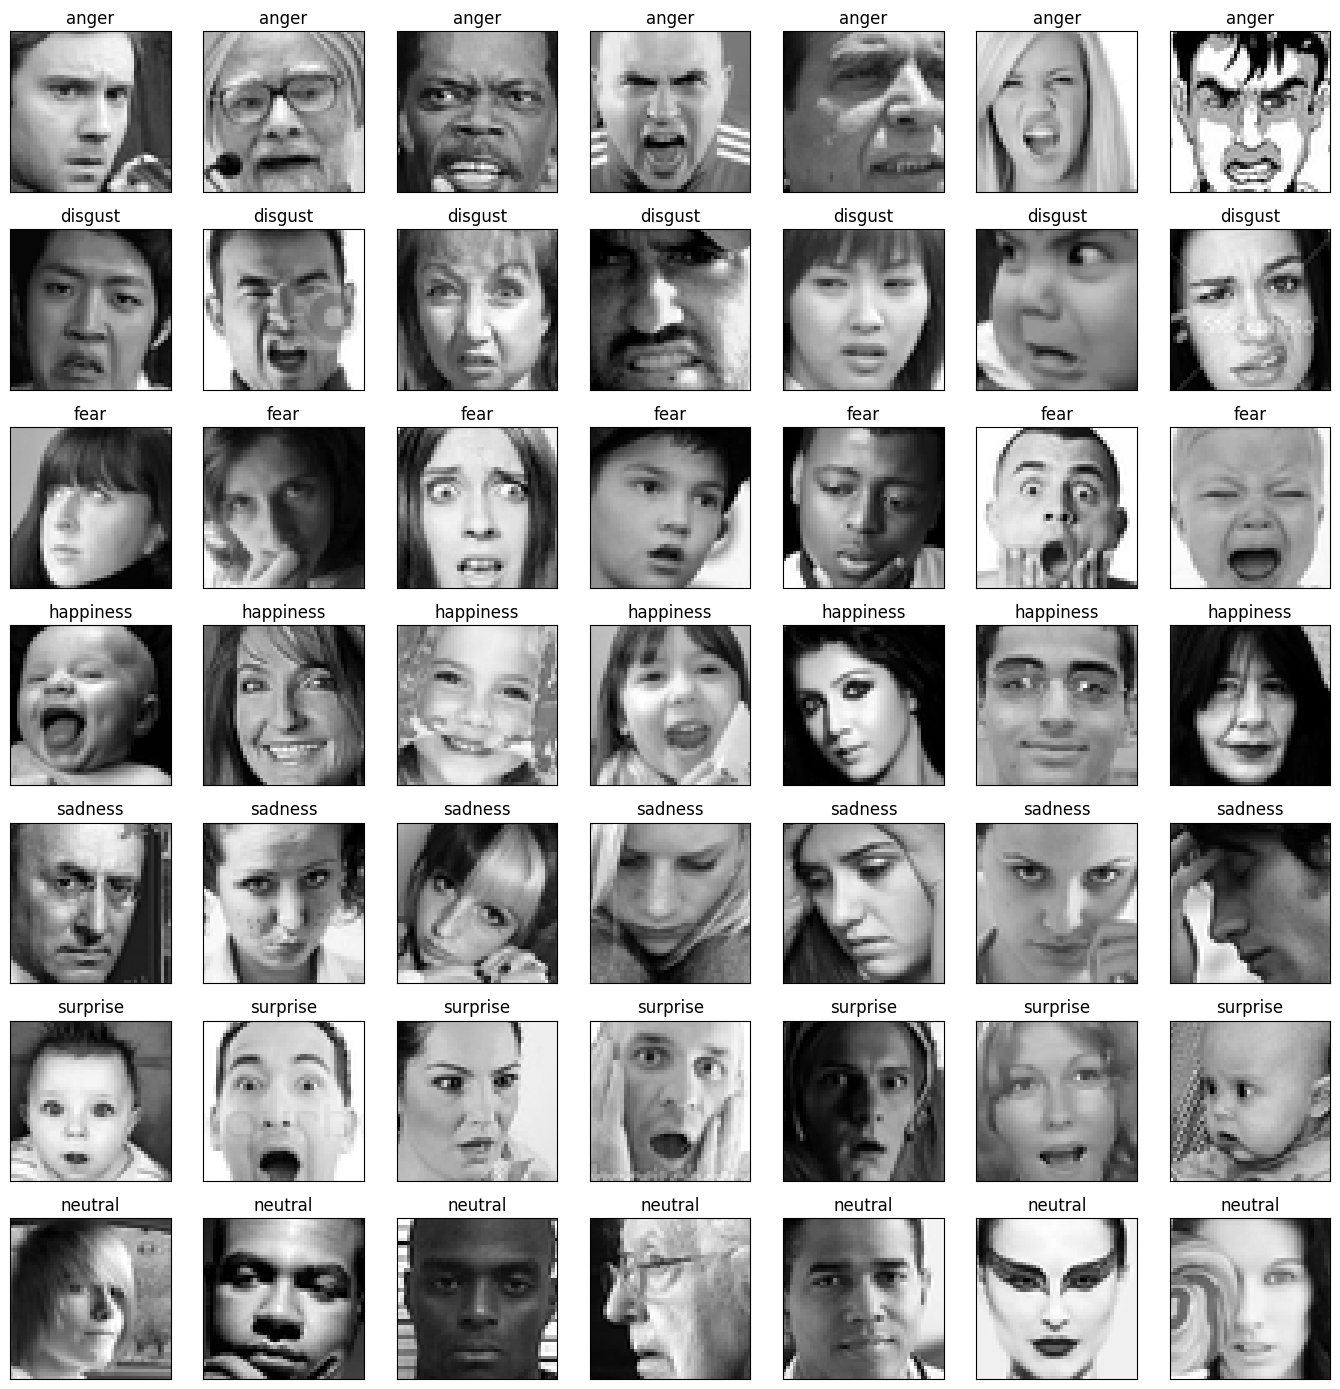

In [11]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [13]:
# INTERESTED_LABELS = [3, 4, 6]
# df = df[df.emotion.isin(INTERESTED_LABELS)]

In [14]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
print("Image array shape:", img_array.shape)

Image array shape: (35887, 48, 48, 1)


In [15]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels) 
print("Label array shape:", img_labels.shape)

Label array shape: (35887, 7)


In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [18]:
del df
del img_array
del img_labels

In [19]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [20]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

def build_net(optim):
    """
    Deep Convolutional Neural Network (DCNN) using ELU activation, He initialization, BatchNormalization, and Dropouts.
    Designed for robust training on image data with categorical output.
    """
    net = Sequential(name='DCNN')

    # Block 1
    net.add(Conv2D(64, (5, 5), activation='elu', padding='same',
                   kernel_initializer='he_normal', input_shape=(img_width, img_height, img_depth), name='conv2d_1'))
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(Conv2D(64, (5, 5), activation='elu', padding='same',
                   kernel_initializer='he_normal', name='conv2d_2'))
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    # Block 2
    net.add(Conv2D(128, (3, 3), activation='elu', padding='same',
                   kernel_initializer='he_normal', name='conv2d_3'))
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(Conv2D(128, (3, 3), activation='elu', padding='same',
                   kernel_initializer='he_normal', name='conv2d_4'))
    net.add(BatchNormalization(name='batchnorm_4'))
    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    # Block 3
    net.add(Conv2D(256, (3, 3), activation='elu', padding='same',
                   kernel_initializer='he_normal', name='conv2d_5'))
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(Conv2D(256, (3, 3), activation='elu', padding='same',
                   kernel_initializer='he_normal', name='conv2d_6'))
    net.add(BatchNormalization(name='batchnorm_6'))
    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    # Fully Connected Layer
    net.add(Flatten(name='flatten'))
    net.add(Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(0.6, name='dropout_4'))

    # Output Layer
    net.add(Dense(num_classes, activation='softmax', name='out_layer'))

    # Compile
    net.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

    # Model Summary
    net.summary()

    return net


In [22]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler,
]

In [23]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [24]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

I0000 00:00:1752221181.534066      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [25]:
model = build_net(optims[1]) 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [26]:

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752221192.896883      97 service.cc:148] XLA service 0x7f9f1c0025a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752221192.897624      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752221193.590882      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  12/1009 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.1218 - loss: 3.5394

I0000 00:00:1752221200.345085      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.2035 - loss: 2.3845 - val_accuracy: 0.3419 - val_loss: 1.6409 - learning_rate: 0.0010
Epoch 2/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.4375 - loss: 1.5564

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.4375 - loss: 1.5564 - val_accuracy: 0.3458 - val_loss: 1.6388 - learning_rate: 0.0010
Epoch 3/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.3238 - loss: 1.6926 - val_accuracy: 0.4528 - val_loss: 1.4437 - learning_rate: 0.0010
Epoch 4/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.4688 - loss: 1.3667 - val_accuracy: 0.4492 - val_loss: 1.4457 - learning_rate: 0.0010
Epoch 5/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4078 - loss: 1.5158 - val_accuracy: 0.5127 - val_loss: 1.2951 - learning_rate: 0.0010
Epoch 6/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - accuracy: 0.3750 - loss: 1.4541 - val_accuracy: 0.5130 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 7/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4652 - loss: 1.4141 - val_accuracy: 0.5272 - val_loss: 1.2548 - learning_rate: 0.0010
Epoch 8/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - accuracy: 0

In [34]:
model.save("model.keras")

In [35]:
model.save_weights("model_weights.weights.h5")

In [36]:
from keras.saving import load_model

In [37]:
model = load_model('/kaggle/input/model/keras/default/1/model.keras')  
model.load_weights('/kaggle/input/model/keras/default/1/model_weights.weights.h5')  

ValueError: File not found: filepath=/kaggle/input/model/keras/default/1/model.keras. Please ensure the file is an accessible `.keras` zip file.

In [52]:
print("Epochs:", history.epoch)
print("Accuracy values:", history.history.get('accuracy'))
print("Validation Accuracy:", history.history.get('val_accuracy'))
print("Loss values:", history.history.get('loss'))
print("Validation Loss:", history.history.get('val_loss'))


Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
Accuracy values: [0.23414739966392517, 0.4375, 0.3455030024051666, 0.46875, 0.42595919966697693, 0.375, 0.4725097715854645, 0.5, 0.4976755678653717, 0.5, 0.5164569616317749, 0.65625, 0.5342155694961548, 0.5625, 0.5455588102340698, 0.25, 0.5608380436897278, 0.5, 0.5635033845901489, 0.53125, 0.572181224822998, 0.625, 0.5732659697532654, 0.65625, 0.5830285549163818, 0.53125, 0.5864377617835999, 0.78125, 0.5904667377471924, 0.5, 0.5951775908470154, 0.40625, 0.5959523916244507, 0.71875, 0.6041963696479797, 0.4375, 0.6037314534187317, 0.75, 0.6094030737876892, 0.75, 0.6118515133857727, 0.53125, 0.6124093532562256, 0.625, 0.61829787

In [53]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6909 - loss: 0.8811
Validation Loss: 0.8801907896995544
Validation Accuracy: 0.6845918297767639


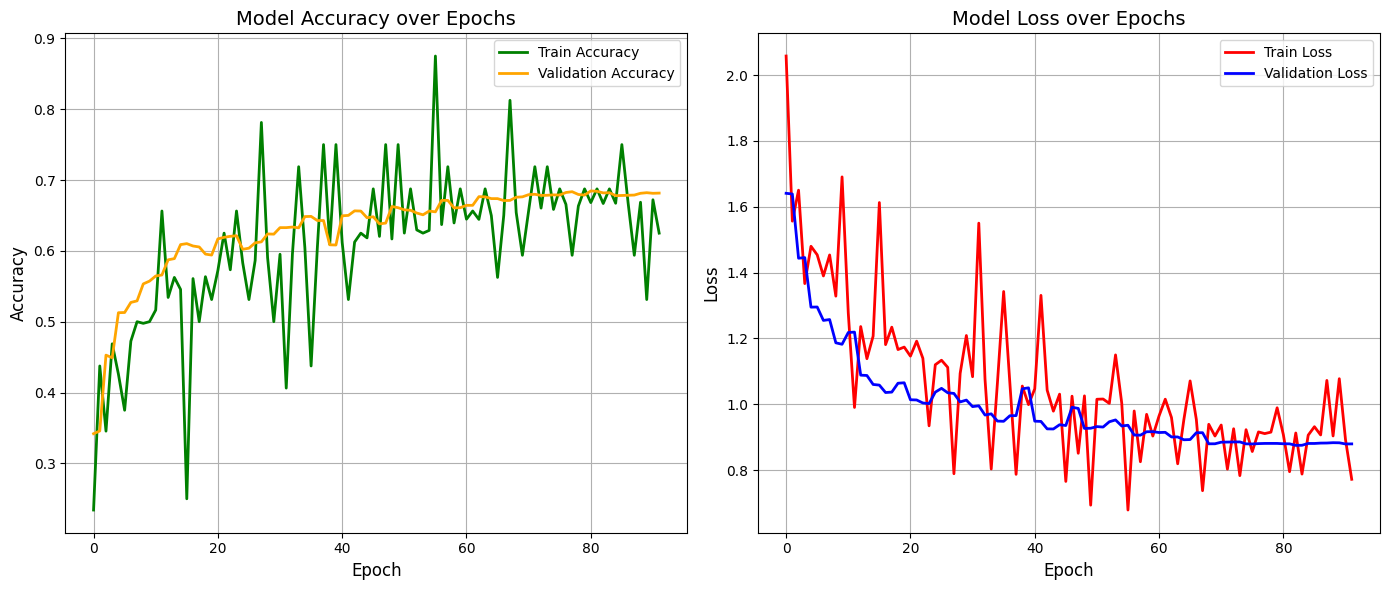

In [47]:
# Plotting training & validation accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


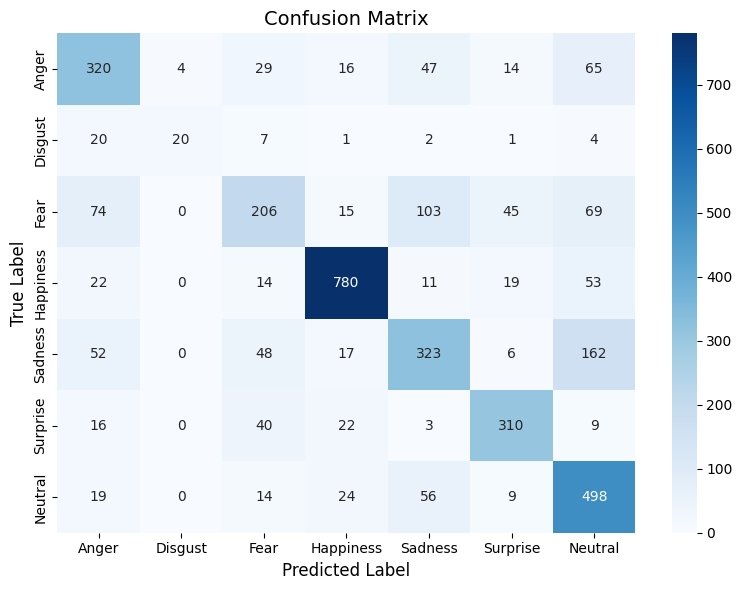

In [48]:
# Predict on validation set
y_pred = model.predict(X_valid)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_valid, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


In [49]:
# Classification Report
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))


Classification Report:

              precision    recall  f1-score   support

       Anger       0.61      0.65      0.63       495
     Disgust       0.83      0.36      0.51        55
        Fear       0.58      0.40      0.47       512
   Happiness       0.89      0.87      0.88       899
     Sadness       0.59      0.53      0.56       608
    Surprise       0.77      0.78      0.77       400
     Neutral       0.58      0.80      0.67       620

    accuracy                           0.68      3589
   macro avg       0.69      0.63      0.64      3589
weighted avg       0.69      0.68      0.68      3589



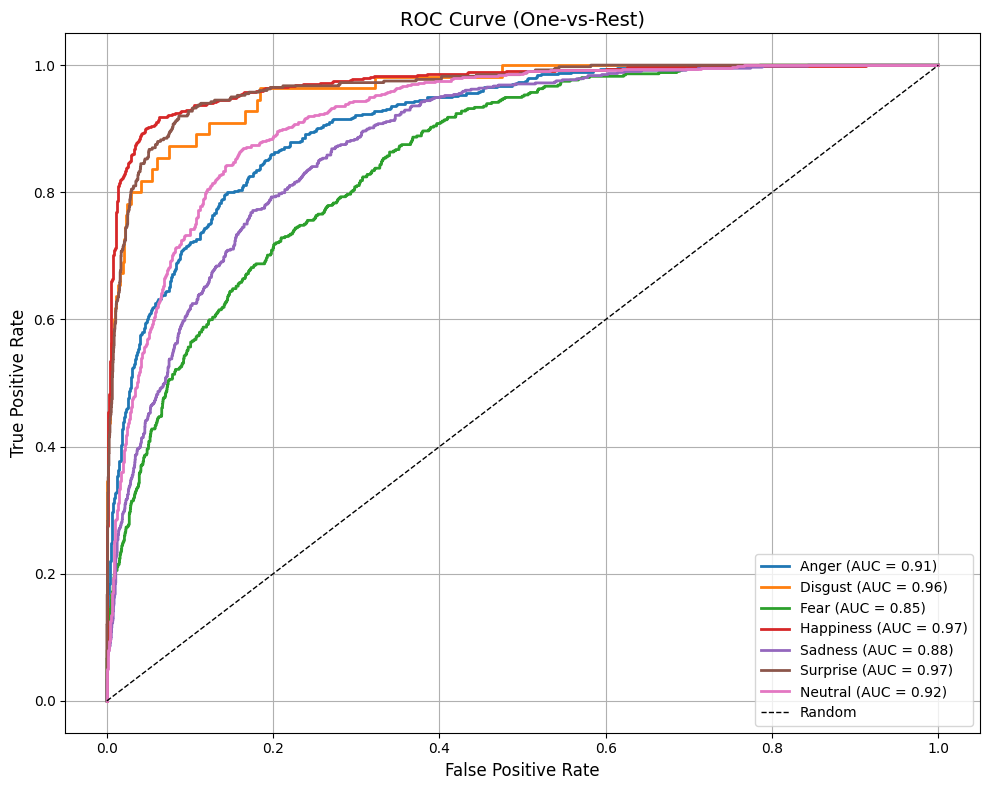

In [50]:
# ROC Curves
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_valid[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.title('ROC Curve (One-vs-Rest)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def build_net(optimizer):
    model = Sequential(name='FER_DCNN')

    # Block 1
    model.add(Conv2D(64, (5, 5), padding='same', activation='elu', kernel_initializer='he_normal', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), padding='same', activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    model.summary()
    return model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, lr_scheduler]

In [ ]:
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)